# Load raster data via WMS

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from owslib.util import Authentication
from owslib.wms import WebMapService
import urllib.parse

from datetime import datetime

import geoengine as ge
from geoengine.colorizer import Colorizer

## Initialize Geo Engine

In [2]:
ge.initialize("http://localhost:3030")

In [3]:
session = ge.get_session()
session

Server:              http://localhost:3030
Session Id:          17009170-3fa1-4c38-bd7f-0d95a1f694a4
Session valid until: 2023-01-23T20:31:58.812Z

## Define workflow of MODIS NDVI raster

In [4]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": "36574dc3-560a-4b09-9d22-d5945f2b8093"
                        }
                    }
                }
            })
workflow

c7b7c5c8-ee11-5418-bd1f-9e5889f6e04a

## Query raster via WMS and Cartopy

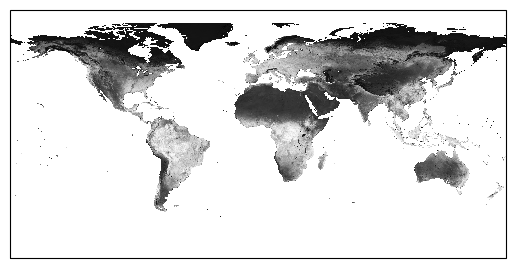

In [5]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1),
)

wms = WebMapService(f'{session.server_url}/wms/{str(workflow)}',
                    version='1.3.0',
                    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
                    timeout=3600)

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_wms(wms,
           layers=[str(workflow)],           
           wms_kwargs={
                'time': urllib.parse.quote(bbox.time_str),
                'crs': bbox.srs,
           })

ax.set_xlim(bbox.spatial_bounds.xmin, bbox.spatial_bounds.xmax)
ax.set_ylim(bbox.spatial_bounds.ymin, bbox.spatial_bounds.ymax)

plt.show()

## Query as image with colorizer option

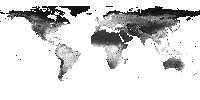

In [6]:
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

workflow.wms_get_map_as_image(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(1.8, 1.8)
        ),
    Colorizer.linear_with_mpl_cmap(map_name="gray", min_max=(0,255))
)

## Query dataframe of point data

In [7]:
ports = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": {
                "type": "internal",
                "datasetId": "a9623a5b-b6c5-404b-bc5a-313ff72e4e75"
            },
            "attributeProjection": None
        }
    }
})

time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

df = ports.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        ge.SpatialResolution(0.1, 0.1)
        )
)

df.head()

,geometry,featurecla,name,natlscale,scalerank,website,start,end
0,POINT (-69.92356 12.43750),Port,Sint Nicolaas,5.0,8,www.rocargo.com/SanNicolas.html,NaT,NaT
1,POINT (-58.95141 -34.15333),Port,Campana,5.0,8,www.consejoportuario.com.ar,NaT,NaT
2,POINT (-59.00495 -34.09889),Port,Zarate,5.0,8,www.consejoportuario.com.ar,NaT,NaT
3,POINT (-62.10088 -38.89444),Port,Puerto Belgrano/Bahia Blanca,5.0,8,None,NaT,NaT
4,POINT (-62.30053 -38.78306),Port,Puerto Galvan/Bahia Blanca,5.0,8,None,NaT,NaT


## Query whole world and combine with points

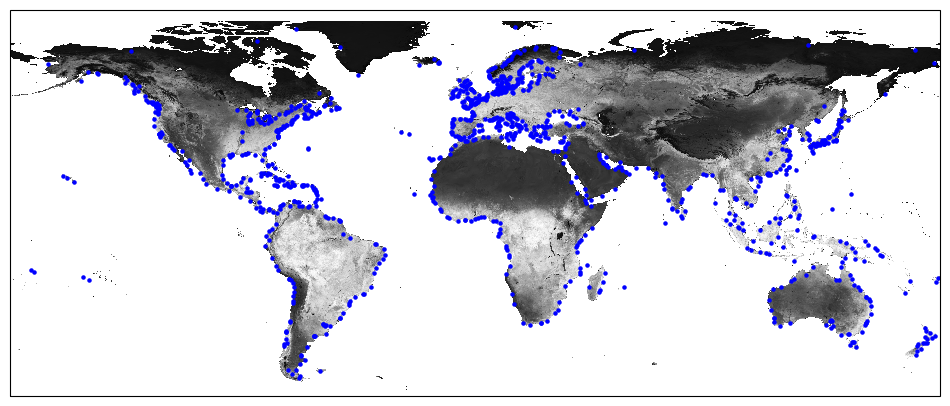

In [8]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1)
)

wms = WebMapService(f'{session.server_url}/wms/{str(workflow)}',
                    version='1.3.0',
                    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
                    timeout=3600)

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())

plt.gca().add_wms(
    wms,
    layers=[str(workflow)],
    wms_kwargs={
        'time': urllib.parse.quote(bbox.time_str),
        'crs': bbox.srs
    }
)

df.plot(markersize=5, marker='o', color='blue', ax=plt.gca())

plt.show()

## Query part of the world and combine with points

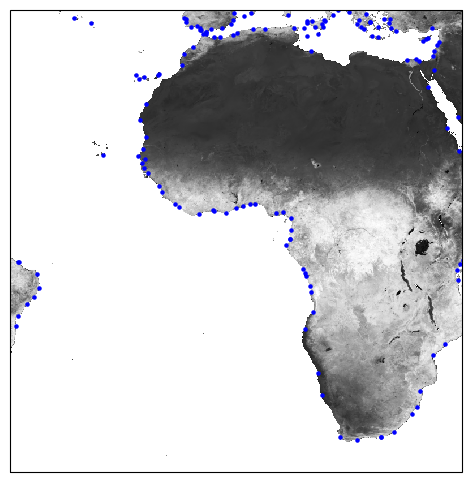

In [9]:
time = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-40.0, -40.0, 40.0, 40.0),
    ge.TimeInterval(time, time),
    ge.SpatialResolution(0.1, 0.1)
)

wms = WebMapService(f'{session.server_url}/wms/{str(workflow)}',
                    version='1.3.0',
                    auth=Authentication(auth_delegate=session.requests_bearer_auth()),
                    timeout=3600)

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())

plt.gca().add_wms(
    wms,
    layers=[str(workflow)],
    wms_kwargs={
        'time': urllib.parse.quote(bbox.time_str),
        'crs': bbox.srs
    }
)

df.plot(markersize=5, marker='o', color='blue', ax=plt.gca())

plt.gca().set_xlim(bbox.spatial_bounds.xmin, bbox.spatial_bounds.xmax)
plt.gca().set_ylim(bbox.spatial_bounds.ymin, bbox.spatial_bounds.ymax)

plt.show()